In [67]:
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, KFold
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, auc
from sklearn.decomposition import PCA
import umap
import json
import cupy

from sklearn.neighbors import KNeighborsClassifier


from tqdm import tqdm

In [49]:
fdir_raw = Path("../data/raw/")
fdir_processed = Path("../data/interim")
fdir_traintest = Path("../data/processed") / 'sex'
fdir_external = Path("../data/external")
ml_models_fdir = Path("../models")

use_CV = True

model_type = 'catboost'
model_type = 'xgboost'
# model_type = 'knn'

feature_importance_method = 'native'
feature_importance_method = 'SHAP'

n_features = 0

value_to_predict = 'Sex'
value_to_predict = 'population'


In [52]:
result_dict = {}
cm_total = np.zeros((5,5))

for organ in ['HEART']:
    result_dict[organ] = {}
    # for sex in ['chrXY', 'chrX', 'chrY', 'autosome']:
    for sex in ['chrXY']:
        result_dict[organ][sex] = {}

        print("*" * 20)
        print(organ)
        print(model_type)
        print(sex)
        print("*" * 20)
        
        with open(ml_models_fdir/f'{model_type}.json', 'r') as file:
            model_params = json.load(file)
        model_params = model_params[value_to_predict]

        data = pd.read_hdf(fdir_traintest / f'geuvadis.preprocessed.sex.h5', key=sex)

        features = pd.read_hdf(
            fdir_processed / f'feature_importance.{model_type}.{"Sex"}.organ_{organ}.h5',
            key=f'{sex}',
        )
        features = features[feature_importance_method]
        # features = features.sort_values(ascending=False)
        
        if organ != "None":
            fname = next((fdir_external / organ / 'reg').glob("*processed.h5"))
            fname = fname.name

            data_eval = pd.read_hdf(fdir_external / organ / 'reg' / fname, index_col=0)
            features = features.loc[features.index.intersection(data_eval.columns)]
            features = features.sort_values(ascending=False)
            
        features_list = features
        
        data_header = pd.read_hdf(fdir_processed / 'geuvadis.preprocessed.h5', key='header')
        
        data = data[features_list.index]
        
        # features = data.columns
    

        X = data.values
        y = data_header[value_to_predict]

        label_encoder = LabelEncoder().fit(y)
        y = label_encoder.transform(y)

        # label_encoder = OneHotEncoder().fit(pd.DataFrame(y))
        # y = y.astype('category')        

        cv = StratifiedKFold(n_splits=5)

        # fig, ax = plt.subplots(figsize=(6, 6))
        for i, (train, val) in tqdm(enumerate(cv.split(X, y))):
            X_train = X[train]
            y_train = y[train]
            X_test = X[val]
            y_test = y[val]

            # train_scaler = StandardScaler().fit(X_train)
            # test_scaler = StandardScaler().fit(X_test)

            train_scaler = RobustScaler().fit(X_train)
            test_scaler = RobustScaler().fit(X_test)

            X_train = train_scaler.transform(X_train)
            X_test = test_scaler.transform(X_test)
            
            X_train_ = X_train
            y_train_ = y_train
            X_val = X_test
            y_val = y_test

            # y_val = label_encoder.transform(pd.DataFrame(y_val)).toarray()
            # y_train_= label_encoder.transform(pd.DataFrame(y_train_)).toarray()

            model_params['enable_categorical'] = True

            model = xgb.XGBClassifier(**model_params)
            model.fit(cupy.array(X_train_), y_train_, eval_set=[(X_val, y_val)], verbose=False)

            pred = model.predict(cupy.array(X_test))
            pred_prob = model.predict_proba(cupy.array(X_test))
            
            cm = confusion_matrix(y_test, y_pred=pred)
            cm_total=cm_total+cm

********************
HEART
xgboost
chrXY
********************


5it [02:48, 33.74s/it]


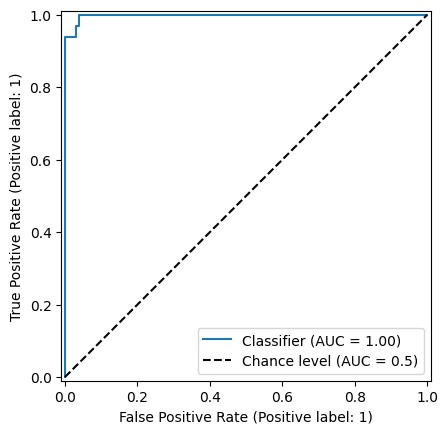

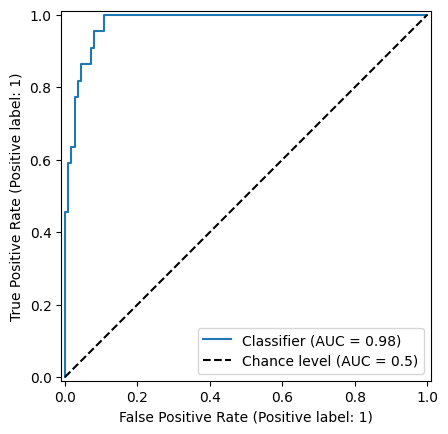

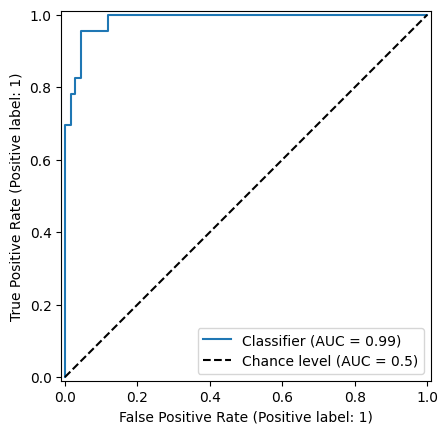

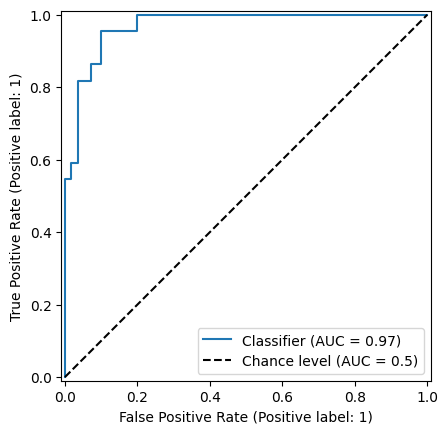

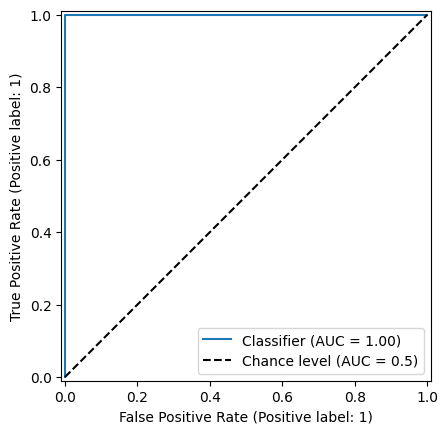

In [68]:
for i in range(pred_prob.shape[1]):
    RocCurveDisplay.from_predictions(
        LabelBinarizer().fit_transform(y_test)[:,i], pred_prob[:,i],
        plot_chance_level=True
)
# features

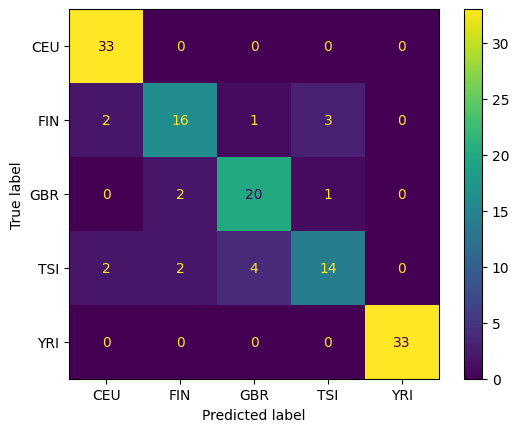

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# cm = confusion_matrix(y_test, y_pred=pred)
disp = ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_)
disp.plot()


In [55]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap_values.mean(axis=2).shape

(133, 8668)

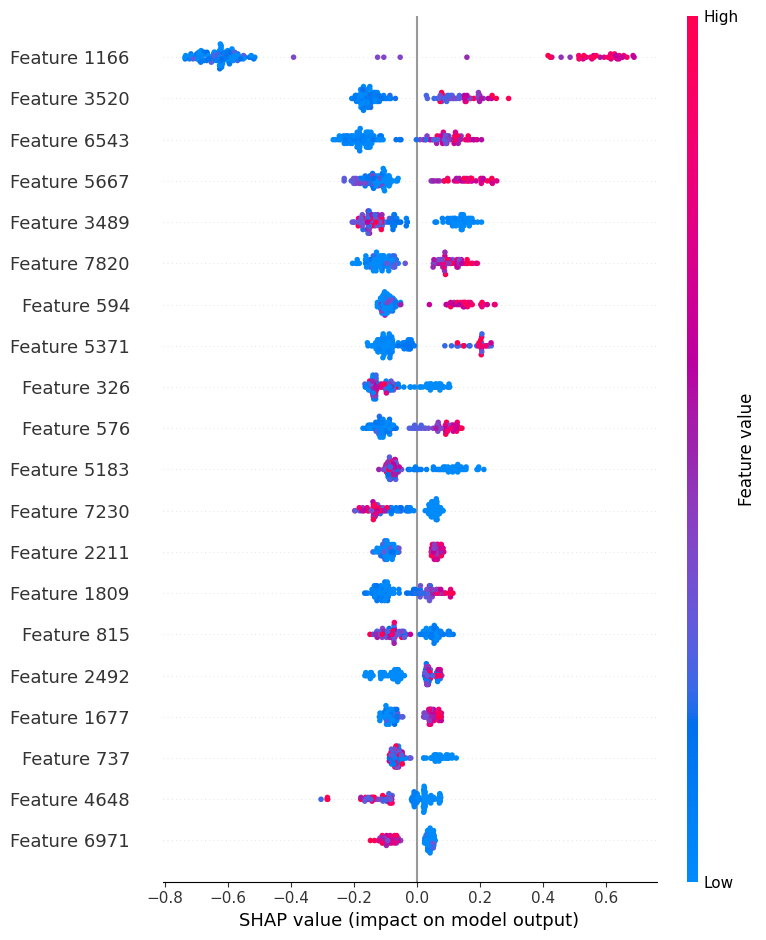

In [56]:
shap.summary_plot(
    shap_values.mean(axis=2), 
    X_test, 
    # plot_type="bar", 
    class_names=model.classes_
    )

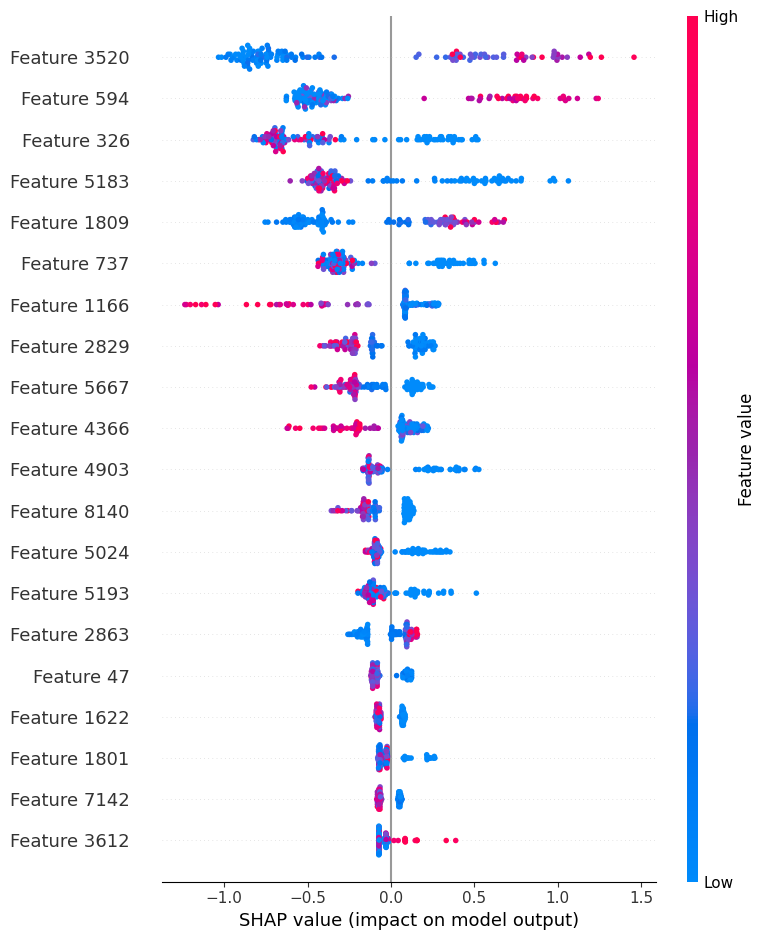

In [57]:
shap.summary_plot(
    shap_values[..., 0], 
    X_test, 
    # plot_type="bar", 
    class_names=model.classes_
    )

In [58]:
data_header.head().T

,ERR188021,ERR188022,ERR188023,ERR188024,ERR188025
Assay Type,RNA-Seq,RNA-Seq,RNA-Seq,RNA-Seq,RNA-Seq
AvgSpotLen,150,150,152,150,152
Bases,4876174200,3348579900,5548298680,3572181450,5348693800
BioProject,PRJEB3366,PRJEB3366,PRJEB3366,PRJEB3366,PRJEB3366
BioSample,SAMEA1573446,SAMEA1573207,SAMEA1573500,SAMEA1573203,SAMEA1573346
Broker_name,ArrayExpress,ArrayExpress,ArrayExpress,ArrayExpress,ArrayExpress
Bytes,3559612733,2387687573,3922060114,2494830964,3609467912
Center Name,UNIGE,UNIGE,CRG,UNIGE,CRG
common_name,human,human,human,human,human
Consent,public,public,public,public,public


<Axes: >

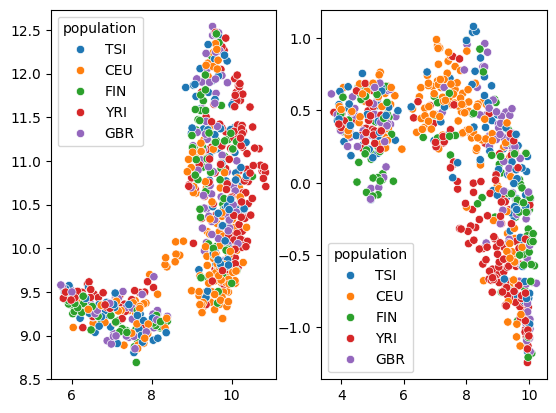

In [65]:
embedding = umap.UMAP(n_components=4)
# embedding = PCA(4)
X_embedded = embedding.fit_transform(StandardScaler().fit_transform(X))

fig, axs = plt.subplots(ncols=2, nrows=1)
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=data_header['population'], ax=axs[0])
sns.scatterplot(x=X_embedded[:, 2], y=X_embedded[:, 3], hue=data_header['population'], ax=axs[1])
# plt.show()

In [73]:
fname = next((fdir_external / "BRAIN1" / 'reg').glob("*processed.h5"))
fname = fname.name

data_eval = pd.read_hdf(fdir_external / "BRAIN1" / 'reg' / fname, index_col=0)
data_eval_header = pd.read_csv(fdir_external / "BRAIN1" / 'reg' / 'SraRunTable.txt', sep=',')

In [76]:
data_eval_header.head().T

,0,1,2,3,4
Run,SRR19147434,SRR19147435,SRR19147436,SRR19147437,SRR19147438
Age,41,28,27,33,40
Assay Type,RNA-Seq,RNA-Seq,RNA-Seq,RNA-Seq,RNA-Seq
AvgSpotLen,150,150,150,150,150
Bases,7616839200,6619489800,6542488950,7159837500,7287900600
BioProject,PRJNA836496,PRJNA836496,PRJNA836496,PRJNA836496,PRJNA836496
BioSample,SAMN28162177,SAMN28162178,SAMN28162179,SAMN28162176,SAMN28162180
BMI,22.6,44.3,34.7,25.8,19.2
Bytes,3213099890,2762942066,2758119959,3009734741,3059329969
Center Name,UNIVERSITY OF PITTSBURGH,UNIVERSITY OF PITTSBURGH,UNIVERSITY OF PITTSBURGH,UNIVERSITY OF PITTSBURGH,UNIVERSITY OF PITTSBURGH


<Axes: >

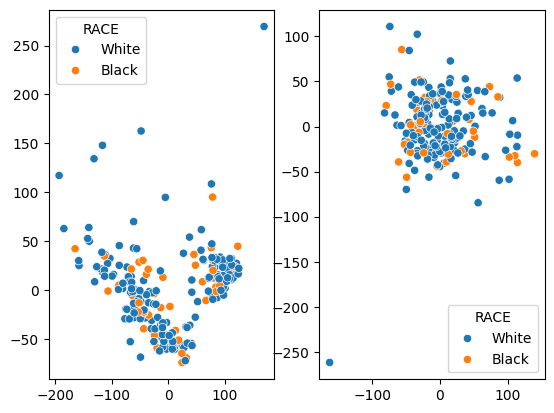

In [80]:
# embedding = umap.UMAP(n_components=4)
embedding = PCA(4)
# X_embedded = embedding.fit_transform(RobustScaler().fit_transform(data_eval.values))
X_embedded = embedding.fit_transform(data_eval.values)

fig, axs = plt.subplots(ncols=2, nrows=1)
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=data_eval_header['RACE'], ax=axs[0])
sns.scatterplot(x=X_embedded[:, 2], y=X_embedded[:, 3], hue=data_eval_header['RACE'], ax=axs[1])
# plt.show()